In [ ]:
# Install the library that has functions to scrape the website: pandas_datareader
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
import pandas_datareader as pdr
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from plotnine import * 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
# Adidas
url = 'https://github.com/robertasgabrys/Forecasting/blob/main/Adidas.xlsx?raw=true'
quarter = pd.read_excel(url, header = None, skiprows = 10, nrows=1, usecols = 'V:DG')
profit = pd.read_excel(url, header = None, skiprows = 21, nrows=1, usecols = 'V:DG')

In [ ]:
# Transpose, and rename the columns
quarter = quarter.transpose().rename(columns={0:'YearQuarter'})
profit = profit.transpose().rename(columns={0:'Profit'})

In [ ]:
# Concatenate quarter and profit into one data frame
df_A = pd.concat([quarter,profit], axis=1).reset_index(drop=True)

In [ ]:
df_A['Trend'] = list(range(1,df_A.shape[0]+1))

In [ ]:
df_A['Quarter']=(df_A.index%4).values
df_A.Quarter=df_A.Quarter.add(1)

In [ ]:
# We define the covid period as 2020 Q1--2021 Q1.

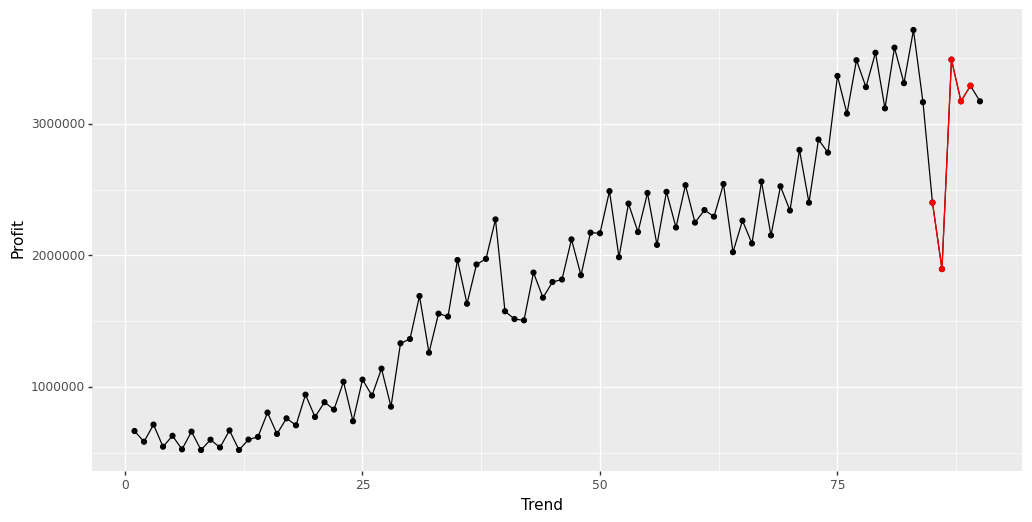

<ggplot: (8784220507457)>

In [ ]:
(
    ggplot(df_A,aes('Trend','Profit')) + geom_point() + geom_line() +
 geom_point(df_A.loc[(df_A.Trend <= 89) & (df_A.Trend >= 85),], aes('Trend','Profit'), color='red') +
 geom_line(df_A.loc[(df_A.Trend <= 89) & (df_A.Trend >= 85),], aes('Trend','Profit'), color='red') +
 theme(figure_size=(12,6)) 
)

In [ ]:
# Create a column BeforeCvoid
df_A['BeforeCovid'] = df_A['Profit']
df_A.loc[df_A['Trend']>=85,'BeforeCovid'] = np.nan

In [ ]:
# M1 = Trend + Seasonal -> BeforeCovid = b0 +b1*Trend + b2...b3 * Seasonal dummies(column Quarter) ->
M1 = smf.ols('BeforeCovid ~ Trend + C(Quarter)',data = df_A).fit()
# old = ordinary least squares = linear regression model
print(M1.summary())

                            OLS Regression Results                            
Dep. Variable:            BeforeCovid   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     353.3
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           1.49e-49
Time:                        06:38:05   Log-Likelihood:                -1147.8
No. Observations:                  84   AIC:                             2306.
Df Residuals:                      79   BIC:                             2318.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.098e+05   6.14e+04     

In [ ]:
# How well model M1 fits the data? Save Predicted/fitted values (estimate of systematic patters) in column M1 in df
df_A['M1'] = M1.fittedvalues

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 6 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 6 rows containing missing values.


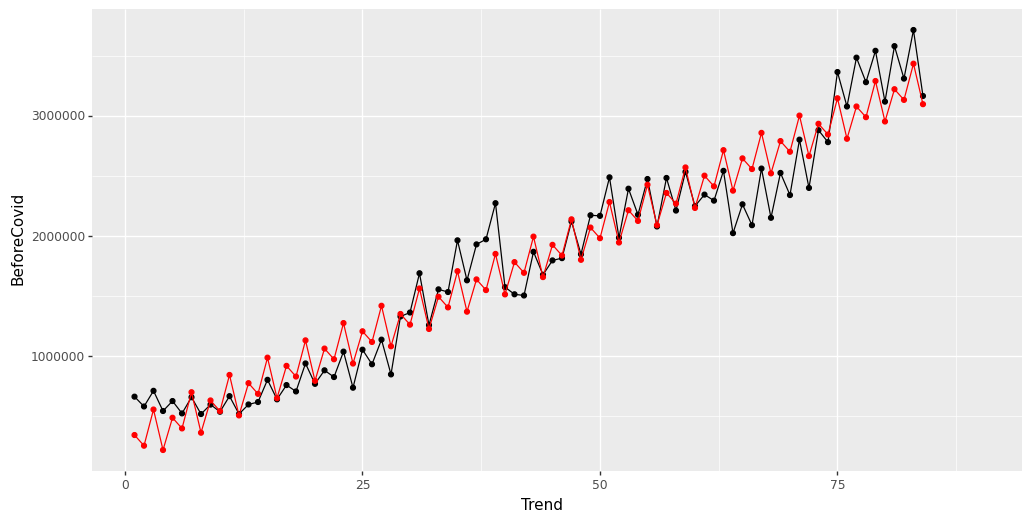

<ggplot: (8784220649309)>

In [ ]:
# Plot data and overlay fitted values
(
    ggplot(df_A,aes('Trend','BeforeCovid')) + geom_point() + geom_line() +
 geom_point(aes('Trend','M1'), color='red') + geom_line(aes('Trend','M1'),color='red') + theme(figure_size = (12,6))
)

In [ ]:
# Store model M1 residuals in column M1residuals in df
df_A['M1residuals'] = M1.resid

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 6 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 6 rows containing missing values.


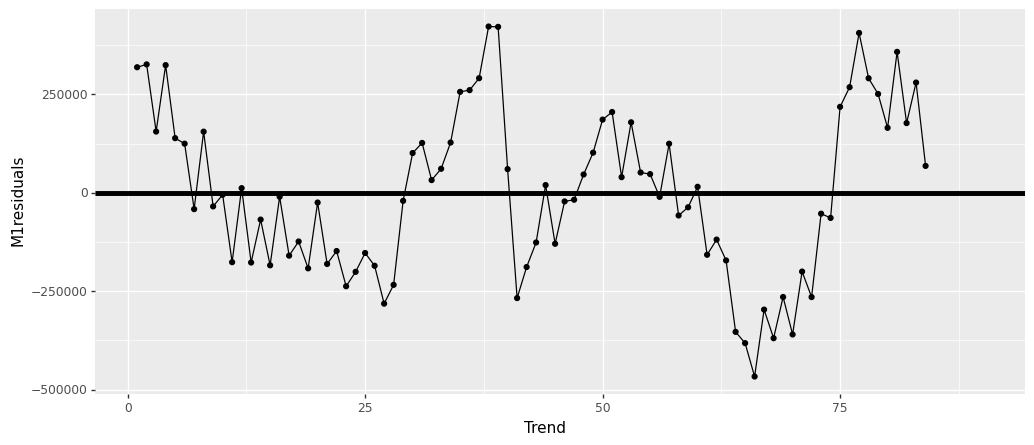

<ggplot: (8784220725893)>

In [ ]:
# Plot data and overlay fitted values
(
    ggplot(df_A,aes('Trend','M1residuals')) + geom_point() + geom_line() + theme(figure_size = (12,5))+
 geom_hline(yintercept=0, size=2)
)

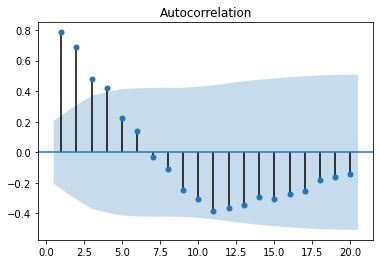

In [ ]:
plot_acf(df_A['M1residuals'],missing='drop',zero=False);

In [ ]:
df_A.loc[df_A['M1residuals'].notna(),'M1residuals']

0     319016.331931
1     326221.847785
2     155542.410641
3     324309.276254
4     138827.214748
          ...      
79    165049.963330
80    358061.008238
81    177086.857266
82    280088.972458
83     68283.502118
Name: M1residuals, Length: 84, dtype: float64

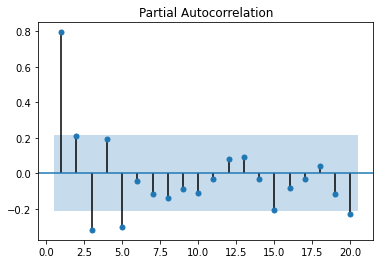

In [ ]:
plot_pacf(df_A.loc[df_A['M1residuals'].notna(),'M1residuals'],zero=False);

In [ ]:
df_A['BeforeCovid1'] = df_A['BeforeCovid'].shift(1)

In [ ]:
# M2 = Trend + Seasonal + Cyclical component
M2 = smf.ols('BeforeCovid ~ Trend + C(Quarter) + BeforeCovid1',data = df_A).fit()
# old = ordinary least squares = linear regression model
print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:            BeforeCovid   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     793.7
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           1.06e-64
Time:                        06:38:07   Log-Likelihood:                -1091.5
No. Observations:                  83   AIC:                             2195.
Df Residuals:                      77   BIC:                             2209.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.498e+05   3.86e+04     

In [ ]:
df_A['M2'] = M2.fittedvalues

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 6 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 6 rows containing missing values.


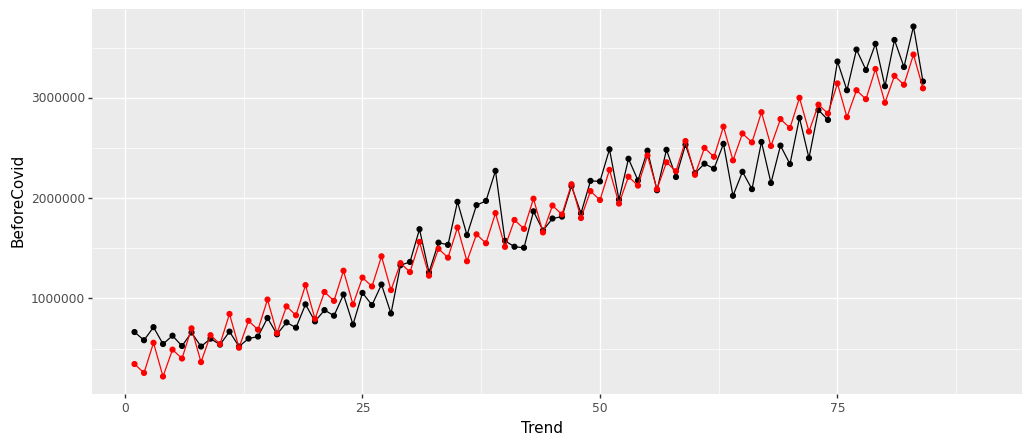

<ggplot: (8784220892125)>

In [ ]:
# Plot data and overlay fitted values
(
    ggplot(df_A,aes('Trend','BeforeCovid')) + geom_point() + geom_line() +
 geom_point(aes('Trend','M1'), color='red') + geom_line(aes('Trend','M1'),color='red') + theme(figure_size = (12,5))
)

In [ ]:
# Since Quarter and trend are known for both pre and recession periods 
# we can use predict function to predict values for both periods
df_A['M1'] = M1.predict(df_A)

In [ ]:
h = df_A['BeforeCovid'].isna().sum()

In [ ]:
for i in list(range(len(df_A) - h, len(df_A))):
    df_A.loc[i,'BeforeCovid1'] = df_A.loc[i-1,'BeforeCovid']
    df_A.loc[i,'BeforeCovid'] = M2.predict(df_A.iloc[[i]]).values
    df_A.loc[i,'M2'] = M2.predict(df_A.iloc[[i]]).values

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


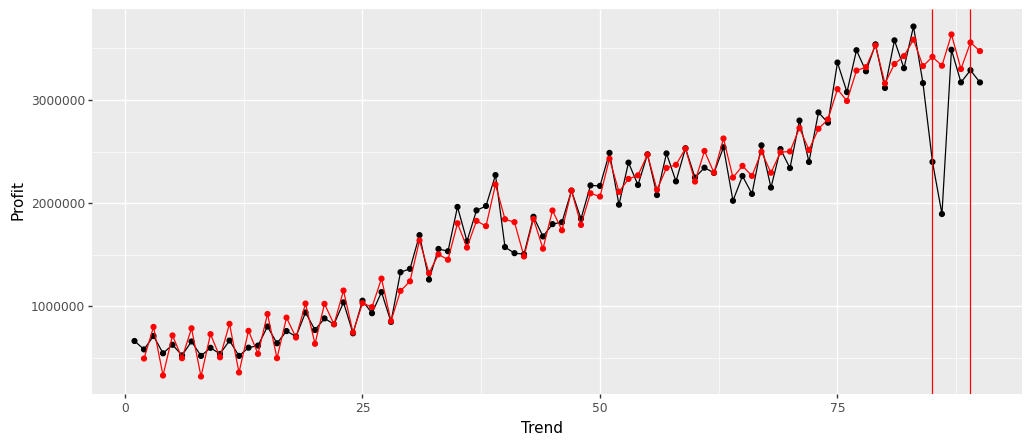

<ggplot: (8784220930197)>

In [ ]:
# Plot data and overlay fitted values
(
    ggplot(df_A,aes('Trend','Profit')) + geom_point() + geom_line() + theme(figure_size = (12,5))+
 geom_vline(xintercept = 85, color ='red', size = 0.5) + geom_vline(xintercept = 89, color='red',size=0.5) +
geom_point(aes('Trend','M2'), color='red') + geom_line(aes('Trend','M2'),color='red')
)

In [ ]:
# impact of COVID = actual Profit - prediction assuming covid has not happened
round((df_A.loc[85:,'Profit'].sum() - df_A.loc[85:,'M2'].sum())*1000,0)

-2287468527.0

In [ ]:
# % impact = 
# (total predicted demand during covid assuming covid has not happened - total actual demand during covid) / total  predicted demand during covid assuming covid has not happened
(df_A.loc[((df_A.Trend <= 89) & (df_A.Trend >= 85)),'M2'].sum() - df_A.loc[((df_A.Trend <= 89) & (df_A.Trend >= 85)),'Profit'].sum()) / df_A.loc[((df_A.Trend <= 89) & (df_A.Trend >= 85)),'M2'].sum()

0.17406425745362217

In [ ]:
# ------------------------------------------------------------------------------------------------NIKE--------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Nike
url = 'https://github.com/robertasgabrys/Forecasting/blob/main/Nike.xlsx?raw=true'
quarter = pd.read_excel(url, header = None, skiprows = 10, nrows=1, usecols = 'B:DJ')
profit = pd.read_excel(url, header = None, skiprows = 21, nrows=1, usecols = 'B:DJ')

In [ ]:
# Transpose, and rename the columns
quarter = quarter.transpose().rename(columns={0:'YearQuarter'})
profit = profit.transpose().rename(columns={0:'Profit'})

In [ ]:
# Concatenate quarter and profit into one data frame
df_N = pd.concat([quarter,profit], axis=1).reset_index(drop=True)

In [ ]:
df_N['Trend'] = list(range(1,df_N.shape[0]+1))

In [ ]:
df_N['Quarter']=(df_N.index%4).values
df_N.Quarter=df_N.Quarter.add(1)

In [ ]:
# We define the covid period as 2020 FQ2--2021 FQ1

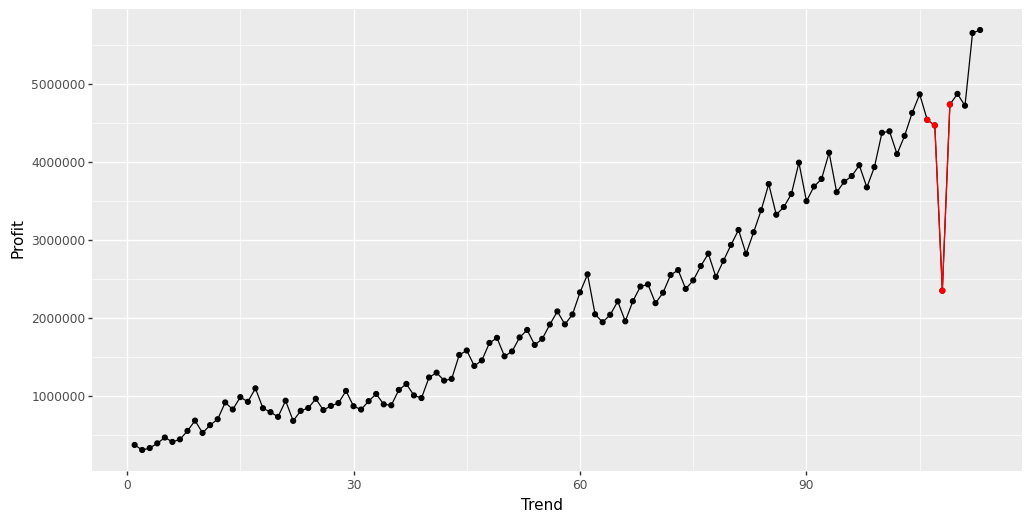

<ggplot: (8784220676669)>

In [ ]:
(
    ggplot(df_N,aes('Trend','Profit')) + geom_point() + geom_line() +
 geom_point(df_N.loc[(df_N.Trend <= 109) & (df_N.Trend >= 106),], aes('Trend','Profit'), color='red') +
 geom_line(df_N.loc[(df_N.Trend <= 109) & (df_N.Trend >= 106),], aes('Trend','Profit'), color='red') +
 theme(figure_size=(12,6)) 
)

In [ ]:
# Create a column BeforeCovid
df_N['BeforeCovid'] = df_N['Profit']
df_N.loc[df_N['Trend']>=106,'BeforeCovid'] = np.nan

In [ ]:
# M1 = Trend + Seasonal -> SalesBefore = b0 +b1*Trend + b2...b3 * Seasonal dummies(column Quarter) ->
# In Python 'SalesBefore ~ Trend + C(Quarter)'  where C stands for categorical and Python will use dummies for column Quarter 
M1 = smf.ols('BeforeCovid ~ Trend + C(Quarter)',data = df_N).fit()
# old = ordinary least squares = linear regression model
print(M1.summary())

                            OLS Regression Results                            
Dep. Variable:            BeforeCovid   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     429.3
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           5.15e-62
Time:                        06:38:11   Log-Likelihood:                -1468.1
No. Observations:                 105   AIC:                             2946.
Df Residuals:                     100   BIC:                             2960.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        9.493e+04   7.54e+04     

In [ ]:
# How well model M1 fits the data? Save Predicted/fitted values (estimate of systematic patters) in column M1 in df
df_N['M1'] = M1.fittedvalues

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 8 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 8 rows containing missing values.


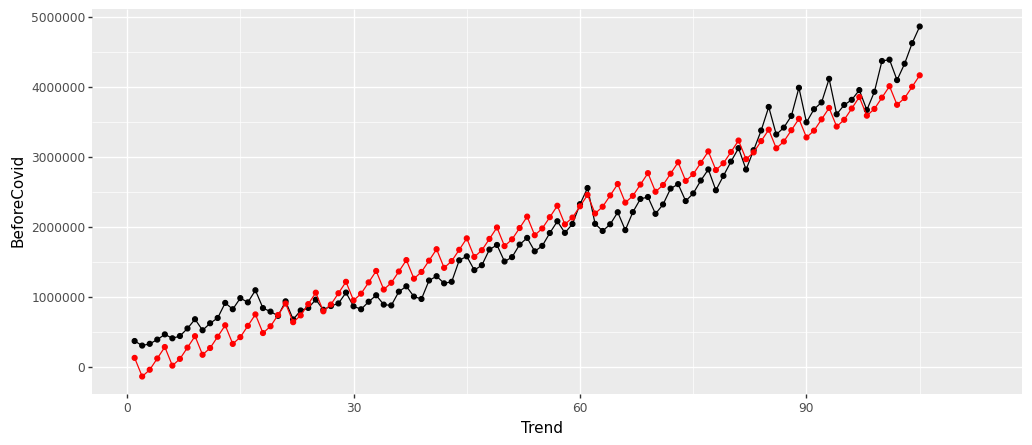

<ggplot: (8784220666377)>

In [ ]:
# Plot data and overlay fitted values
(
    ggplot(df_N,aes('Trend','BeforeCovid')) + geom_point() + geom_line() +
 geom_point(aes('Trend','M1'), color='red') + geom_line(aes('Trend','M1'),color='red') + theme(figure_size = (12,5))
)

In [ ]:
# Store model M1 residuals in column M1residuals in df
df_N['M1residuals'] = M1.resid

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 8 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 8 rows containing missing values.


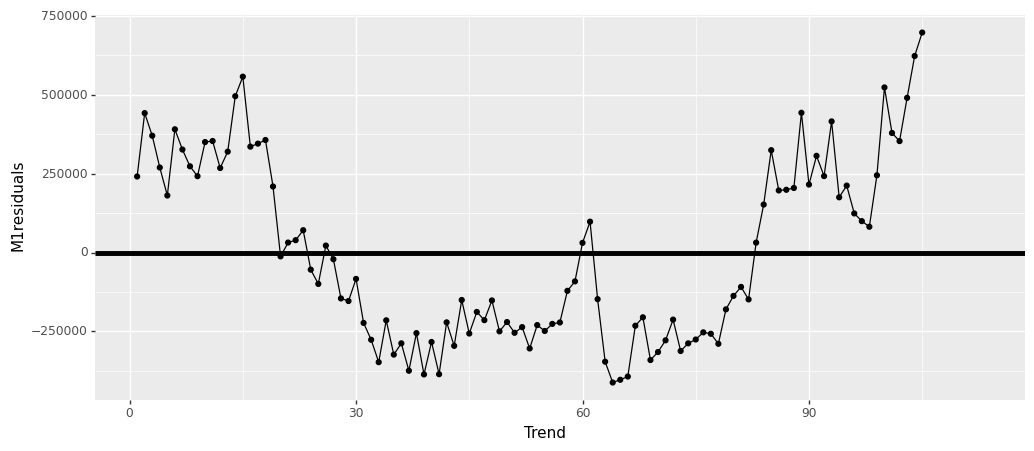

<ggplot: (8784220921321)>

In [ ]:
# Plot data and overlay fitted values
(
    ggplot(df_N,aes('Trend','M1residuals')) + geom_point() + geom_line() + theme(figure_size = (12,5))+
 geom_hline(yintercept=0, size=2)
)

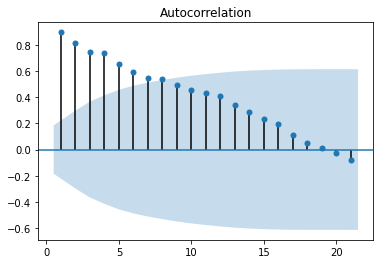

In [ ]:
plot_acf(df_N['M1residuals'],missing='drop',zero=False);

In [ ]:
df_A.loc[df_N['M1residuals'].notna(),'M1residuals']

0     319016.331931
1     326221.847785
2     155542.410641
3     324309.276254
4     138827.214748
          ...      
85              NaN
86              NaN
87              NaN
88              NaN
89              NaN
Name: M1residuals, Length: 90, dtype: float64

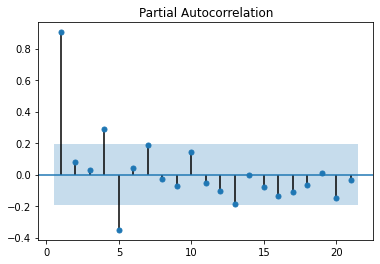

In [ ]:
plot_pacf(df_N.loc[df_N['M1residuals'].notna(),'M1residuals'],zero=False);

In [ ]:
df_N['BeforeCovid1'] = df_N['BeforeCovid'].shift(1)

In [ ]:
# M2 = Trend + Seasonal + Cyclical component
M2 = smf.ols('BeforeCovid ~ Trend + C(Quarter) + BeforeCovid1',data = df_N).fit()
# old = ordinary least squares = linear regression model
print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:            BeforeCovid   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2496.
Date:                Tue, 18 Oct 2022   Prob (F-statistic):          1.29e-101
Time:                        06:38:12   Log-Likelihood:                -1352.1
No. Observations:                 104   AIC:                             2716.
Df Residuals:                      98   BIC:                             2732.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.223e+05   2.94e+04     

In [ ]:
df_N['M2'] = M2.fittedvalues

In [ ]:
# Since Quarter and trend are known for both pre and recession periods 
# we can use predict function to predict values for both periods
# Note that the predict function for pre recession period gives fitted values
df_N['M1'] = M1.predict(df_N)

In [ ]:
h = df_N['BeforeCovid'].isna().sum()

In [ ]:
for i in list(range(len(df_N) - h, len(df_N))):
    df_N.loc[i,'BeforeCovid1'] = df_N.loc[i-1,'BeforeCovid']
    df_N.loc[i,'BeforeCovid'] = M2.predict(df_N.iloc[[i]]).values
    df_N.loc[i,'M2'] = M2.predict(df_N.iloc[[i]]).values

In [ ]:
df_N.tail(12)

,YearQuarter,Profit,Trend,Quarter,BeforeCovid,M1,M1residuals,BeforeCovid1,M2
101,2019 FQ2,4105000,102,2,4.105000e+06,3.751609e+06,353391.145050,4.397000e+06,4.164739e+06
102,2019 FQ3,4339000,103,3,4.339000e+06,3.848428e+06,490571.721973,4.105000e+06,4.211443e+06
103,2019 FQ4,4633000,104,4,4.633000e+06,4.009744e+06,623256.029666,4.339000e+06,4.503527e+06
104,2020 FQ1,4871000,105,1,4.871000e+06,4.173237e+06,697762.712334,4.633000e+06,4.784230e+06
105,2020 FQ2,4544000,106,2,4.625936e+06,3.906973e+06,NaN,4.871000e+06,4.625936e+06
106,2020 FQ3,4473000,107,3,4.717383e+06,4.003792e+06,NaN,4.625936e+06,4.717383e+06
107,2020 FQ4,2353000,108,4,4.873577e+06,4.165108e+06,NaN,4.717383e+06,4.873577e+06
108,2021 FQ1,4741000,109,1,5.022915e+06,4.328601e+06,NaN,4.873577e+06,5.022915e+06
109,2021 FQ2,4877000,110,2,4.780104e+06,4.062337e+06,NaN,5.022915e+06,4.780104e+06
110,2021 FQ3,4725000,111,3,4.873698e+06,4.159156e+06,NaN,4.780104e+06,4.873698e+06


/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


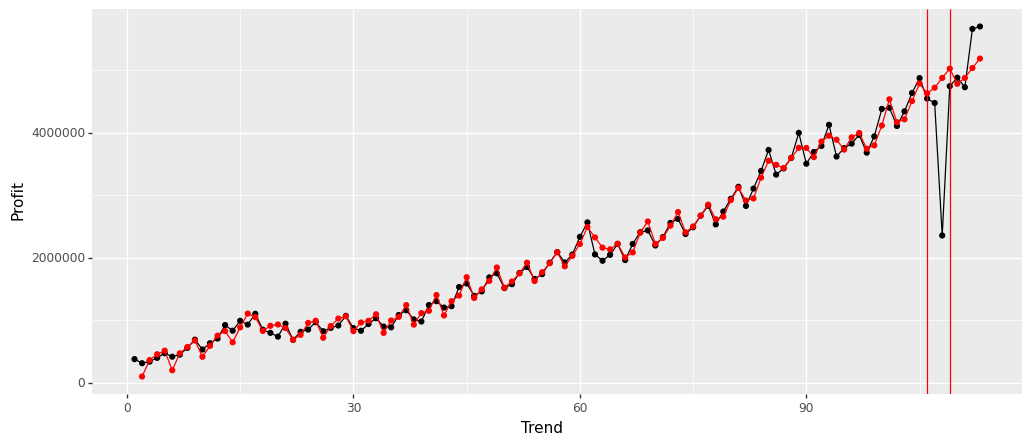

<ggplot: (8784220817433)>

In [ ]:
# Plot data and overlay fitted values
(
    ggplot(df_N,aes('Trend','Profit')) + geom_point() + geom_line() + theme(figure_size = (12,5))+
 geom_vline(xintercept = 106, color ='red', size = 0.5) + geom_vline(xintercept = 109, color='red',size=0.5) +
geom_point(aes('Trend','M2'), color='red') + geom_line(aes('Trend','M2'),color='red')
)

In [ ]:
# impact of COVID = actual Profit - prediction assuming covid has not happened
round((df_N.loc[106:,'Profit'].sum() - df_N.loc[106:,'M2'].sum())*1000,0)

-1959842833.0

In [ ]:
# % impact = 
# (total predicted demand during covid assuming covid has not happened - total actual demand during covid) / total  predicted demand during covid assuming covid has not happened
(df_N.loc[((df_N.Trend <= 109) & (df_N.Trend >= 106)),'M2'].sum() - df_N.loc[((df_N.Trend <= 109) & (df_N.Trend >= 106)),'Profit'].sum()) / df_N.loc[((df_N.Trend <= 109) & (df_N.Trend >= 106)),'M2'].sum()

0.16262171665938088